In [13]:
# import libraries
import pandas as pd
import numpy as np 
from prophet import Prophet
import logging
import datetime
import pickle

In [2]:
# Initialize the logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [3]:
def load_data(path):
    try:
        df = pd.read_csv(path, low_memory=False)
        return df
    except Exception as e:
        logger.info(f"Error on Loding Data {e}")

In [4]:
path = "../data/02_intermediate/train_clean.csv"
df = load_data(path)


In [5]:
logger.info("Checking the dataframe")
df.head()

2024-06-01 22:32:18,114 - INFO - Checking the dataframe


,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Week,Month,Year,Season
0,0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,...,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
1,1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
2,2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
3,3,4,5,2015-07-31,13995.0,NaN,1,1,0,1,...,2009.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
4,4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,...,2015.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer


In [5]:
# Function to create features from Prophet model
def create_prophet_features(df, date_col):
    try: 
        logger.info("Creating Prophet features")
        df_prophet = df[[date_col, 'Sales']].rename(columns={date_col: 'ds', 'Sales': 'y'})
        return df_prophet
    except Exception as e:
        logger.info(f"Error {e}")
        

In [6]:
prophet_df = create_prophet_features(df, "Date")

logger.info("Checking the df")
prophet_df.head()

2024-06-01 23:08:41,165 - INFO - Creating Prophet features
2024-06-01 23:08:41,541 - INFO - Checking the df


,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [7]:
def create_prophet_model(df):
    logger.info("Create model")
    try: 
        model = Prophet(interval_width=0.95)
        model.fit(df)
        future = model.make_future_dataframe(periods=365)
        forecast = model.predict(future)
        return model, forecast
    except Exception as e:
        logger.info("Error on creating model {e}")

In [8]:
model, forecast = create_prophet_model(prophet_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

2024-06-01 23:08:48,978 - INFO - Create model
2024-06-01 23:08:51,529 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-01 23:09:13,339 - DEBUG - input tempfile: /tmp/tmpr5zp_wuf/cm77hpvj.json
2024-06-01 23:12:17,747 - DEBUG - input tempfile: /tmp/tmpr5zp_wuf/l2n3ddp9.json
2024-06-01 23:12:20,564 - DEBUG - idx 0
2024-06-01 23:12:21,490 - DEBUG - running CmdStan, num_threads: None
2024-06-01 23:12:21,575 - DEBUG - CmdStan args: ['/home/derbew/Documents/10a/Rossmann_Store_Sales_Analysis/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9367', 'data', 'file=/tmp/tmpr5zp_wuf/cm77hpvj.json', 'init=/tmp/tmpr5zp_wuf/l2n3ddp9.json', 'output', 'file=/tmp/tmpr5zp_wuf/prophet_modelya6xprs2/prophet_model-20240601231220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:12:21 - cmdstanpy - INFO - Chain [1] start processing
2024-06-01 23:12:21,626 - INFO - Chain [1] start processing
23:15:20 - cmd

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,5710.804088,613.320591,10930.129376
1,2013-01-02,5356.086695,460.646396,9999.894567
2,2013-01-03,5059.209154,248.768206,9547.248680
3,2013-01-04,5538.195144,577.972841,10265.062033
4,2013-01-05,4733.314252,-42.113066,9275.773969


Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

- __ds__: the datestamp of the forecasted value
- __yhat__: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- __yhat_lower__: the lower bound of our forecasts
- __yhat_upper__: the upper bound of our forecasts

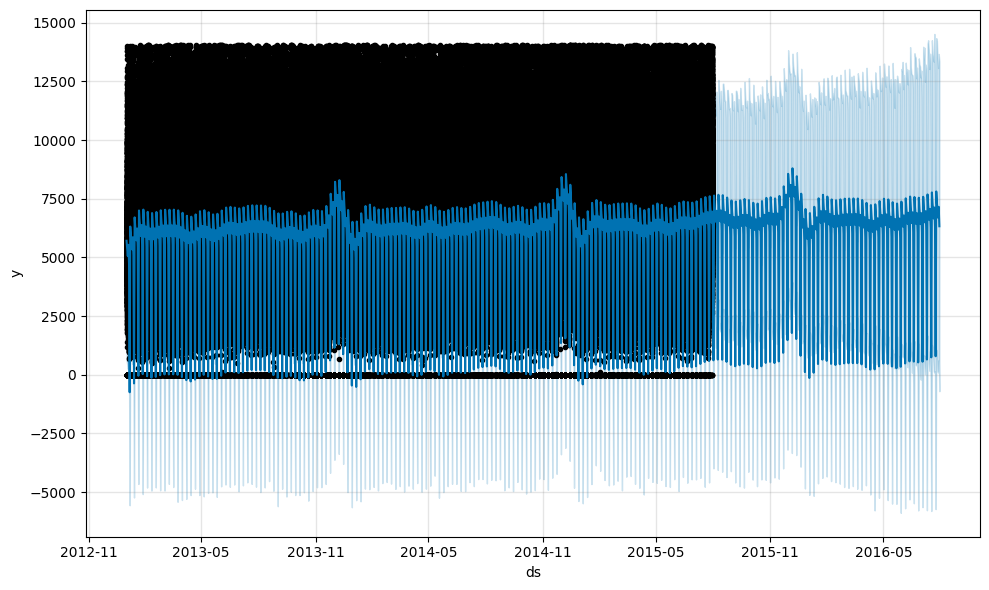

In [10]:
fig1 = model.plot(forecast)

/home/derbew/Documents/10a/Rossmann_Store_Sales_Analysis/myenv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/derbew/Documents/10a/Rossmann_Store_Sales_Analysis/myenv/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/derbew/Documents/10a/Rossmann_Store_Sales_Analysis/myenv/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is depre

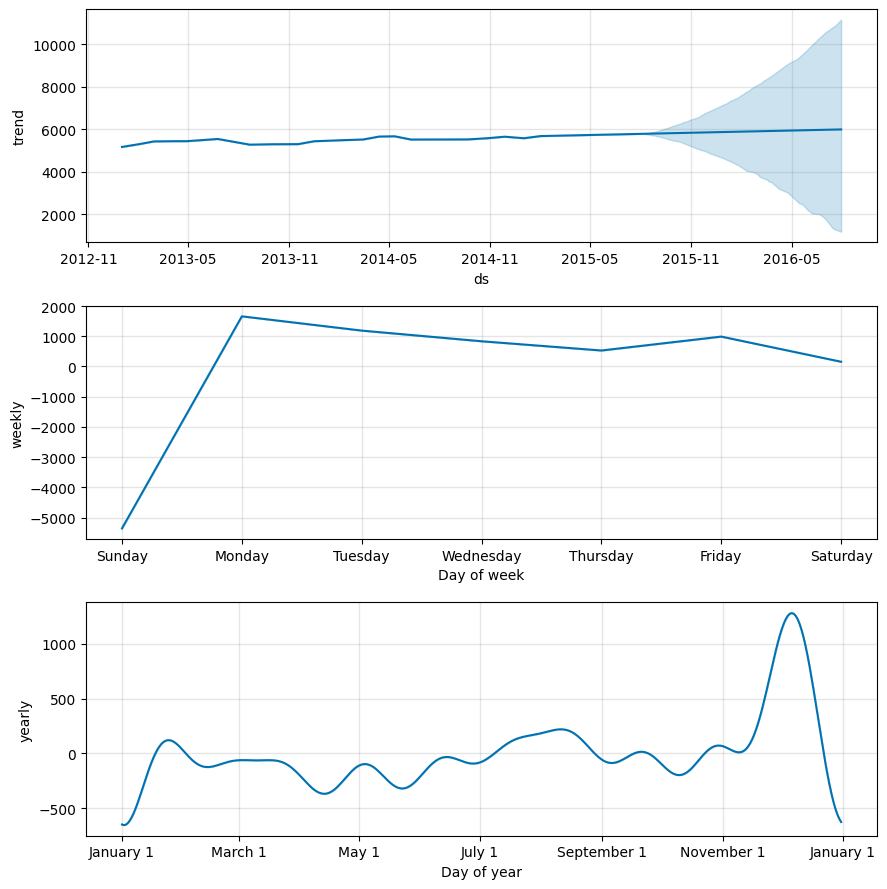

In [11]:
fig2 = model.plot_components(forecast)

#  Serialize the model

In [15]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
filename = f'model_{timestamp}.pkl'
pickle.dump(model, open(filename, 'wb'))